In [1]:
%load_ext autoreload
%autoreload 2

import torch

from torch.utils.data import DataLoader

from src.deep_ad.config import Config
from src.deep_ad.data.dagm_split import dagm_patch_get_splits
from src.deep_ad.image import plot_losses, plot_images
from src.deep_ad.model import DeepCNN
from src.deep_ad.save_manager import SaveManager
from src.deep_ad.trainer import Trainer, create_optimizer
from src.deep_ad.transforms import create_training_transform, create_validation_transform

In [10]:
# Load the configuration
# config = Config(root_dir="..", config_path="../save/checkpoints/7_class_10_1_batch_weights_init/config.yml")
config = Config(root_dir="..", config_path="../default_config.yml")
print(config)

Datasets:
dagm_lengths: [0.8, 0.1, 0.1]
raw_patch_size: 176
patch_size: 128
ppi: 4
patches_iou_threshold: 0.05

PyTorch:
seed: 42
device: cuda

Training:
batch_size: 32
init_weights: True
loss_type: l1_norm
loss_Lambda: 0.9
loss_N: 16384
optim_lr: 0.0002
optim_adam_betas: (0.9, 0.999)
optim_adam_eps: 1e-08
train_epochs: 1


### Test the trainer

In [11]:
# Load the datasets
train_transform = create_training_transform(config)
val_transform = create_validation_transform(config)
train_dataset, val_dataset, test_dataset = dagm_patch_get_splits(config, train_transform, val_transform, classes=[10])

In [12]:
# Create the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

In [13]:
# Load the model
model = DeepCNN(config).to(config.device)
model_num_params = sum(p.numel() for p in model.parameters())
print(f"Model has {model_num_params:,} parameters")

Model has 1,447,713 parameters


In [14]:
# Create the trainer
run_name = f"test"
print(f"Run name: {run_name}")
trainer = Trainer(
    config,
    model,
    train_dataloader,
    val_dataloader,
    run_name=run_name,
    train_epochs=3,
    limit_batches=1,
    save_epochs=[3],
)

Run name: test


In [15]:
# Start training
train_losses, val_losses = trainer.train()

	Batch   1/100: Loss 0.001875
Epoch   1/3: Train Loss 0.001875, Val Loss 0.001726, time 4.984 s
Checkpoint saved at '..\save\checkpoints\test\best.pt'
	Batch   1/100: Loss 0.001105
Epoch   2/3: Train Loss 0.001105, Val Loss 0.001778, time 5.511 s
	Batch   1/100: Loss 0.000910
Epoch   3/3: Train Loss 0.000910, Val Loss 0.001869, time 5.420 s
Checkpoint saved at '..\save\checkpoints\test\epoch_3.pt'
Training finished.


In [16]:
# Clear cache after training
torch.cuda.empty_cache()

In [19]:
# Load the best model
model_best = DeepCNN().to(config.device)
optimizer_best = create_optimizer(model_best, config)
model_best, optimizer_best, train_losses, val_losses, epoch = SaveManager.load_checkpoint(
    model=model_best,
    optimizer=optimizer_best,
    path=SaveManager.get_checkpoint_path(config, run_name=run_name, name="epoch_100"),
)

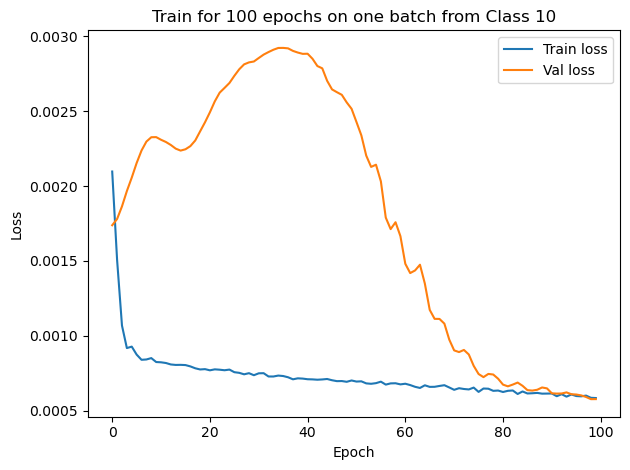

In [16]:
# Plot the losses
%matplotlib inline
plot_losses(torch.asarray(train_losses), torch.asarray(val_losses), title="Train for 100 epochs on one batch from Class 10", save_path=f"../save/plots/{run_name}.png")

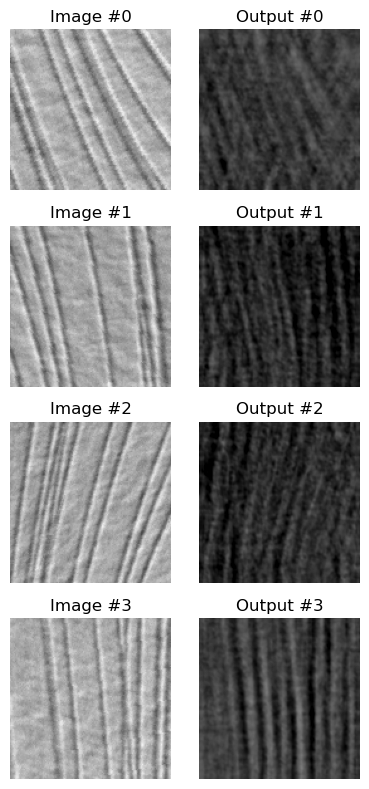

In [18]:
def flatten(xs):
    return [x for ys in xs for x in ys]

images, keys = next(iter(train_dataloader))
input_images = []
outputs = []
for i in range(4):
    image = images[i]
    input_images.append(image.squeeze().detach().cpu().numpy())
    input = image.unsqueeze(0).to(config.device)
    input[48:80, 48:80] = 0
    output = model(input)
    outputs.append(output.squeeze().detach().cpu().numpy())
titles = flatten([[f"Image #{i}", f"Output #{i}"] for i in range(4)])
plot_images(flatten(list(zip(input_images, outputs))), titles, rows=4, cols=2, figsize=(4, 8))

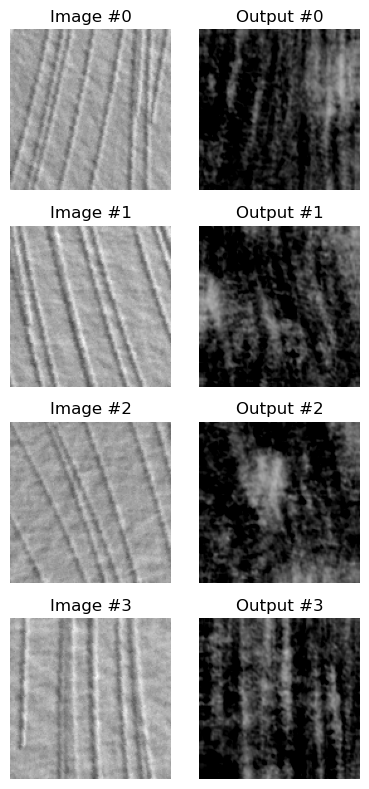

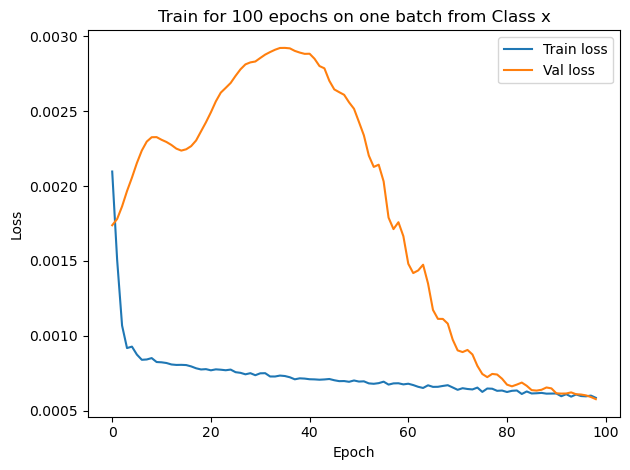

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import os


def flatten(xs):
    return [x for ys in xs for x in ys]


run_dirs = next(os.walk("../save/checkpoints"))
run_names = run_dirs[1]

for run_name in run_names[8:]:
    cpt_dir = f"../save/checkpoints/{run_name}"
    config = Config(root_dir="..", config_path=f"{cpt_dir}/config.yml")
    model_best = DeepCNN(config).to(config.device)
    optimizer_best = create_optimizer(model_best, config)
    model_best, optimizer_best, train_losses, val_losses, epoch = SaveManager.load_checkpoint(
        model=model_best,
        optimizer=optimizer_best,
        path=SaveManager.get_checkpoint_path(config, run_name=run_name, name="best"),
    )

    plot_dir = f"../save/plots/{run_name}"
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)

    images, keys = next(iter(train_dataloader))
    input_images = []
    outputs = []
    for i in range(4):
        image = images[i]
        input_images.append(image.squeeze().detach().cpu().numpy())
        input = image.unsqueeze(0).to(config.device)
        input[48:80, 48:80] = 0
        output = model_best(input)
        outputs.append(output.squeeze().detach().cpu().numpy())
    titles = flatten([[f"Image #{i}", f"Output #{i}"] for i in range(4)])
    plot_images(flatten(list(zip(input_images, outputs))), titles, rows=4, cols=2, figsize=(4, 8))
    plt.savefig(f"{plot_dir}/eval.png")
    plot_losses(
        torch.asarray(train_losses),
        torch.asarray(val_losses),
        title=f"Train for {config.train_epochs} epochs on one batch from Class x",
        save_path=f"{plot_dir}/losses.png",
    )